In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import itertools
from collections import defaultdict

In [2]:
class Grid:
    def __init__(self, minute_part, hours = 24):
        self.hours = hours
        self.minute_part = minute_part
        self.Grid = pd.DataFrame(None, columns= [(y, x) for y in range(hours) for x in range(minute_part)], dtype = bool)
        
    def insert(self, idx, times: list):
            
        self.Grid.loc[idx] = [ x in set(times) for x in self.Grid.columns]
        
    def delete(self, idx):
        if idx in self.Grid.index:
            self.Grid.drop(index=idx, inplace= True)
        else:
            print("Not in index")
    
    def change(self, idx, times: list, value):
        self.Grid.loc[idx] = [ value if x in set(times) else y for x,y in zip(self.Grid.columns, self.Grid.loc[idx])]
    
    def isAvailable(self, idx, times: list):
        if idx not in self.Grid.index:
            print("Not an appropriate index")
            return False
        
        pos = self.Grid.index.get_loc(idx)
        return self.Grid.iloc[pos, times[0]*self.minute_part + times[1]]
    
    def getTotal(self, times):
        return self.Grid[times].sum()
    def getTotalbyidx(self, idx):
        return self.Grid.loc[idx].sum()
    
    def getAvailable(self, time):
        return self.Grid.loc[self.Grid[time] == True][time]
    
    def getEntropy(self):
        EntropybyRow = np.zeros(shape=(self.Grid.shape[0],1))
        EntropybyCol = np.zeros(shape=(1,self.Grid.shape[1]))

        for count, person in enumerate(self.Grid.index):
            prob = self.getTotalbyidx(person)/self.Grid.shape[1]

            EntropybyRow[count] = entropy([prob, 1-prob])

        for count, time in enumerate(self.Grid):
            prob = self.getTotal(time)/self.Grid.shape[0]
        
            EntropybyCol[0,count] = entropy([prob, 1-prob])
    
        EntTable = EntropybyCol+EntropybyRow
        EntTable[~self.Grid.to_numpy()] = np.inf
        
        return EntTable
    
    def getMutualInformation(self):
        ProbByRow = np.zeros(shape=(self.Grid.shape[0],1))
        ProbByCol = np.zeros(shape=(1,self.Grid.shape[1]))
        
        for count, person in enumerate(self.Grid.index):
            prob = self.getTotalbyidx(person)/self.Grid.shape[1]

            ProbByRow[count] = prob

        for count, time in enumerate(self.Grid):
            prob = self.getTotal(time)/self.Grid.shape[0]
        
            ProbByCol[0,count] = prob
            
        probTable = ProbByRow * ProbByCol
        
        for row in range(probTable.shape[0]):
            for col in range(probTable.shape[1]):
                probTable[row, col] = entropy([probTable[row,col], 1-probTable[row,col]])
        
        #print(probTable)
        return self.getEntropy() - probTable
        
    def getNextAvailable(self, time):
        ser = self.getAvailable(time)
        return ser.sort_index(key = lambda x: [self.getTotalbyidx(y) for y in x])
    def print(self):
        print(self.Grid)
    

In [3]:
class Person:
    newid = itertools.count()
    def __init__(self, id = None, availability= set()):
        if id is None:
            self.id = next(Person.newid)
        else:
            self.id = id
            
        self.availability = set()
        
    def reset():
        Person.newid = itertools.count()
        
            

In [4]:
print (pd.options.display.max_columns)
print (pd.options.display.max_rows)

20
60


In [5]:
test = Grid(4, hours = 4)
#test.print()
test.insert(20, [(0,0),(0,3),(2,2)])

test.insert(0, [(0,3)])
test.insert(3, [(0,0)])
test.change(3, [(1,0)], True)

print("Test is Available: ", test.isAvailable(3, (1,1)), "\n" )
display(test.getAvailable((0,0)) )
print("\nTest Total by Row: ", test.getTotalbyidx(20))
print("Test Total by Column: ", test.getTotal((0,0)), "\n" )

display(test.getNextAvailable((0,0)) )
display(test.Grid)
print(test.Grid.shape)

Test is Available:  False 



20    True
3     True
Name: (0, 0), dtype: bool


Test Total by Row:  3
Test Total by Column:  2 



3     True
20    True
Name: (0, 0), dtype: bool

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(2, 0)","(2, 1)","(2, 2)","(2, 3)","(3, 0)","(3, 1)","(3, 2)","(3, 3)"
20,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


(3, 16)


In [6]:
test.delete(4)
test.getTotal((2,2))

Not in index


1

In [7]:
test.print()

    (0, 0)  (0, 1)  (0, 2)  (0, 3)  (1, 0)  (1, 1)  (1, 2)  (1, 3)  (2, 0)  \
20    True   False   False    True   False   False   False   False   False   
0    False   False   False    True   False   False   False   False   False   
3     True   False   False   False    True   False   False   False   False   

    (2, 1)  (2, 2)  (2, 3)  (3, 0)  (3, 1)  (3, 2)  (3, 3)  
20   False    True   False   False   False   False   False  
0    False   False   False   False   False   False   False  
3    False   False   False   False   False   False   False  


In [8]:
test.isAvailable(4, (2,2))

Not an appropriate index


False

In [9]:
test.isAvailable(3, (1,0))

True

# Things to try
min value of matrix

# Calculate the loss H(P(x)/m*n) + H(M(x)/X)
- Entropy of the person plus entropy of the space
    - minimize such that the total entropy of remaining spaces is the most possible
- where E(P(x)/m*n) is the entropy for person,P, and P(x) is total available
- where E(M(x)/X) is the entropy of available People, M(x), against total People, X
# Operations:
How to keep track of positions
How to deal with failure end state (is it reversible?)
How to represent success state (used dictionary)
Best way to find next position (sorted numpy array along index)

# Failure States:
When X > m*n
When dictionary reaches inf.
# Success state:
When all values in Dictonary are unique

In [10]:
HOUR_PARTITIONS = 48
HOURS = 24
Num_People = 26
def fillGrid(perc):
    return perc* (HOUR_PARTITIONS*HOURS)
people = [Person() for x in range(Num_People)]

In [11]:
schedule = Grid(HOUR_PARTITIONS)

def createTupList(Hours, Minutes, size):
    #s = set()
    #while len(s) != size:
    #    s.add(tuple(np.random.randint(maxval, size = 2, dtype = np.uint64)))
    #print("\n", list(s))
    #print("Length of list: ", len(s))
    #return list(s)
    return [(np.random.randint(Hours, dtype=np.uint64), np.random.randint(Minutes, dtype=np.uint64)) for x in range(size)]

for person in people:
    r_size = np.random.randint(schedule.Grid.shape[1], dtype = np.uint64)
    #print(person.id)
    schedule.insert(person.id, createTupList(HOURS, HOUR_PARTITIONS, r_size))
    
schedule.print()

    (0, 0)  (0, 1)  (0, 2)  (0, 3)  (0, 4)  (0, 5)  (0, 6)  (0, 7)  (0, 8)  \
0    False   False   False   False   False   False   False   False    True   
1    False   False    True    True   False   False    True   False    True   
2    False    True   False    True    True    True   False   False   False   
3     True   False    True    True   False   False    True    True    True   
4    False   False   False   False   False   False   False   False    True   
5    False   False   False   False   False   False   False   False   False   
6     True    True    True   False   False   False   False   False    True   
7    False   False   False    True   False   False   False   False   False   
8    False   False    True   False    True   False   False    True   False   
9    False   False    True   False   False   False   False   False    True   
10    True    True   False    True   False    True    True   False    True   
11   False   False   False   False   False   False   False   Fal

In [12]:
out = ""
for count, person in enumerate(people, 1):
    out += str(person.id) + " Person available in " + str(schedule.getTotalbyidx(person.id)) + " Spots\t\t"
    if count % 2 == 0:
        print(out)
        out = ""

if out != "":
    print(out)

0 Person available in 372 Spots		1 Person available in 550 Spots		
2 Person available in 411 Spots		3 Person available in 734 Spots		
4 Person available in 353 Spots		5 Person available in 133 Spots		
6 Person available in 680 Spots		7 Person available in 224 Spots		
8 Person available in 192 Spots		9 Person available in 165 Spots		
10 Person available in 266 Spots		11 Person available in 60 Spots		
12 Person available in 316 Spots		13 Person available in 18 Spots		
14 Person available in 9 Spots		15 Person available in 719 Spots		
16 Person available in 522 Spots		17 Person available in 595 Spots		
18 Person available in 604 Spots		19 Person available in 736 Spots		
20 Person available in 2 Spots		21 Person available in 132 Spots		
22 Person available in 560 Spots		23 Person available in 534 Spots		
24 Person available in 167 Spots		25 Person available in 646 Spots		


In [13]:
out = ""
for count, person in enumerate(people, 1):
    out += str(person.id) + " Person available {:.4%} of times\t".format(schedule.getTotalbyidx(person.id)/schedule.Grid.shape[1])
    if count % 2 == 0:
        print(out)
        out = ""
if out != "":
    print(out)

0 Person available 32.2917% of times	1 Person available 47.7431% of times	
2 Person available 35.6771% of times	3 Person available 63.7153% of times	
4 Person available 30.6424% of times	5 Person available 11.5451% of times	
6 Person available 59.0278% of times	7 Person available 19.4444% of times	
8 Person available 16.6667% of times	9 Person available 14.3229% of times	
10 Person available 23.0903% of times	11 Person available 5.2083% of times	
12 Person available 27.4306% of times	13 Person available 1.5625% of times	
14 Person available 0.7812% of times	15 Person available 62.4132% of times	
16 Person available 45.3125% of times	17 Person available 51.6493% of times	
18 Person available 52.4306% of times	19 Person available 63.8889% of times	
20 Person available 0.1736% of times	21 Person available 11.4583% of times	
22 Person available 48.6111% of times	23 Person available 46.3542% of times	
24 Person available 14.4965% of times	25 Person available 56.0764% of times	


In [14]:
disp = pd.DataFrame(schedule.getEntropy(), columns= schedule.Grid.columns)

In [15]:
display(disp)

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)",...,"(23, 38)","(23, 39)","(23, 40)","(23, 41)","(23, 42)","(23, 43)","(23, 44)","(23, 45)","(23, 46)","(23, 47)"
0,inf,inf,inf,inf,inf,inf,inf,inf,1.319234,inf,...,1.322196,1.246290,inf,inf,inf,inf,inf,1.322196,inf,1.169253
1,inf,inf,1.309370,1.373394,inf,inf,1.274620,inf,1.382314,inf,...,inf,inf,1.309370,1.309370,inf,1.309370,1.309370,1.385275,inf,inf
2,inf,1.296571,inf,1.332803,1.317816,1.268779,inf,inf,inf,1.234030,...,1.344685,1.268779,1.268779,inf,inf,inf,1.268779,inf,inf,inf
3,1.237531,inf,1.272281,1.336305,inf,inf,1.237531,1.237531,1.345224,1.237531,...,1.348186,1.272281,1.272281,inf,1.144591,1.272281,inf,1.348186,1.321317,inf
4,inf,inf,inf,inf,inf,inf,inf,inf,1.306395,1.198701,...,inf,inf,inf,inf,1.105761,inf,inf,1.309356,inf,inf
5,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
6,1.259250,1.321790,1.293999,inf,inf,inf,inf,inf,1.366943,inf,...,1.369904,inf,1.293999,1.293999,1.166309,1.293999,1.293999,1.369904,1.343036,1.216961
7,inf,inf,inf,1.173869,inf,inf,inf,inf,inf,inf,...,inf,inf,1.109845,inf,inf,inf,1.109845,1.185751,inf,inf
8,inf,inf,1.067803,inf,1.116840,inf,inf,1.033053,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,1.116840,inf
9,inf,inf,1.028024,inf,inf,inf,inf,inf,1.100968,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [16]:
pd.DataFrame(schedule.getMutualInformation(), columns= schedule.Grid.columns)

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)",...,"(23, 38)","(23, 39)","(23, 40)","(23, 41)","(23, 42)","(23, 43)","(23, 44)","(23, 45)","(23, 46)","(23, 47)"
0,inf,inf,inf,inf,inf,inf,inf,inf,0.898197,inf,...,0.880115,0.922618,inf,inf,inf,inf,inf,0.880115,inf,0.904078
1,inf,inf,0.892073,0.870245,inf,inf,0.891020,inf,0.854960,inf,...,inf,inf,0.892073,0.892073,inf,0.892073,0.892073,0.835681,inf,inf
2,inf,0.922734,inf,0.908465,0.917932,0.922733,inf,inf,inf,0.917705,...,0.875748,0.922733,0.922733,inf,inf,inf,0.922733,inf,inf,inf
3,0.779210,inf,0.777407,0.753479,inf,inf,0.779210,0.779210,0.739468,0.779210,...,0.722394,0.777407,0.777407,inf,0.772656,0.777407,inf,0.722394,0.764476,inf
4,inf,inf,inf,inf,inf,inf,inf,inf,0.898851,0.913871,...,inf,inf,inf,inf,0.881754,inf,inf,0.881116,inf,inf
5,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
6,0.821373,0.815448,0.820152,inf,inf,inf,inf,inf,0.781276,inf,...,0.763215,inf,0.820152,0.820152,0.812507,0.820152,0.820152,0.763215,0.807373,0.818923
7,inf,inf,inf,0.889603,inf,inf,inf,inf,inf,inf,...,inf,inf,0.883349,inf,inf,inf,0.883349,0.866814,inf,inf
8,inf,inf,0.865530,inf,0.878730,inf,inf,0.849924,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,0.878730,inf
9,inf,inf,0.847353,inf,inf,inf,inf,inf,0.857521,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [17]:
points = [] # [ [[],[]], ...]
for idx, row in disp.iterrows():
    data = []
    col = []
    for count, (pt, column) in enumerate(zip(row,disp.columns)):
        if schedule.isAvailable(idx, column):
            col.append(count)
            data.append(pt)
    points.append([col, data])

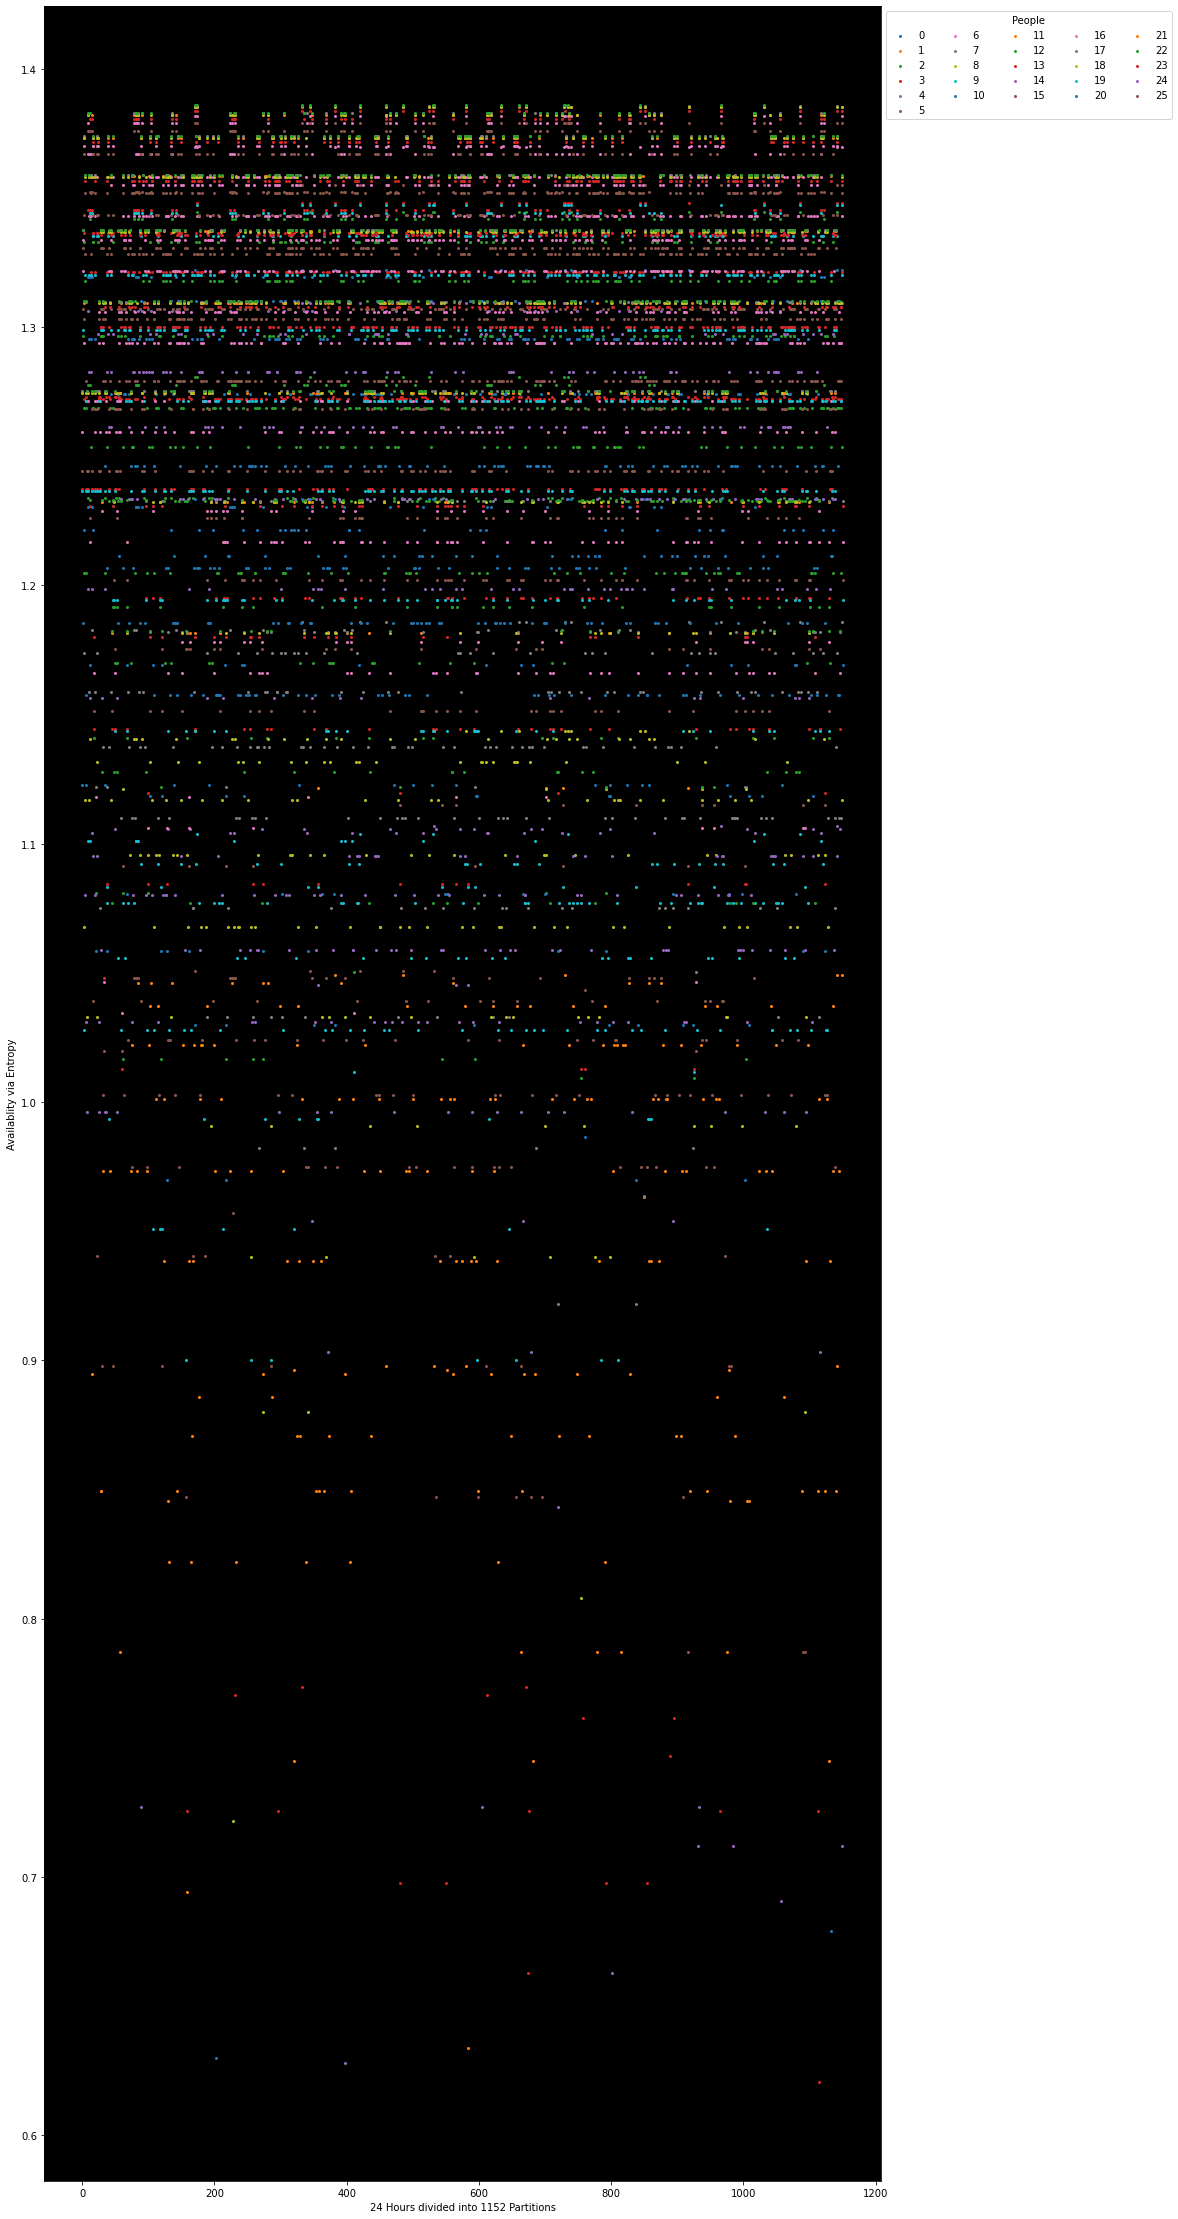

In [18]:
fig , ax = plt.subplots()

for pts, idx in zip(points, disp.index):
    ax.scatter(pts[0], pts[1], s = 4, label = idx)
    
ax.legend(title = "People", loc = "upper left", bbox_to_anchor = (1, 1), ncol = math.floor(math.sqrt(disp.shape[0])), fancybox = True)

ax.set_facecolor('black')
ax.set_xlabel("{Hours:} Hours divided into {Min_part} Partitions".format(Hours=HOURS, Min_part = HOURS*HOUR_PARTITIONS))
ax.set_ylabel("Availablity via Entropy")
fig.set_figwidth(15)
fig.set_figheight(40)

#plot = plt.scatter(np.arange(len(disp.columns))+ np.zeros(shape=(len(disp.index), 1), dtype = int), disp.to_numpy())
plt.show()

In [19]:
def getBestSpot(people, grid):
    
    #EntTable = grid.getEntropy()
    EntTable = grid.getMutualInformation()
    #print(EntTable.shape)
    
    tableInd = EntTable.argsort(axis=1)
 
    best = {person.id: table[0] for person, table in zip(people ,tableInd)}
    idxCt = {}
    for k in best:
        idxCt[k] = 0
        
    #print(best)
    while len(set(best.values())) != len(best):
        last = {}
        for count, k in enumerate(best):
            best[k] = tableInd[count, idxCt[k]]
            
            if best[k] not in last:
                last[best[k]] = k
                #print(last)
            else:
                #compare with last instance of the entropy table index
                #print("Index: ", last[best[k]] , " Entropy: ", EntTable[ last[best[k]], best[ last[best[k]] ] ])
                #print("Second Index: ", k, " Entropy: ", EntTable[count, best[k]])
                test_last = tableInd[last[best[k]], idxCt[last[best[k]]]+1 ]
                test_new = tableInd[count, idxCt[k]+1]
                if EntTable[ last[best[k]] , best[ last[best[k]] ] ] > EntTable[count, best[k]]:
                    #print("Index: ", last[best[k]] , " Entropy: ", EntTable[ last[best[k]], best[ last[best[k]] ] ])
                    #print("Second Index: ", k, " Entropy: ", EntTable[count, best[k]])
                    
                    
                    if not np.isinf(EntTable[ last[best[k]], test_last]):
                        idxCt[ last[best[k]] ] += 1
                    else:
                        print("Testing Other... ")
                        if not np.isinf(EntTable[count, test_new]):
                            idxCt[k] += 1
                        else:
                            print("Unresolvable")
                            return None
                else:
                    if not np.isinf(EntTable[count, test_new]):
                        idxCt[k] += 1
                    else:
                        print("Testing Other... ")
                        if not np.isinf(EntTable[ last[best[k]], test_last]):
                            idxCt[ last[best[k]] ] += 1
                        else:
                            print("Unresolvable")
                            return None
                    
                #update to current instance
                last[best[k]] = k
        
    return best, tableInd, idxCt, EntTable

best, idxes, idxCts, Entropy = getBestSpot(people, schedule)

In [20]:
def getBestSpot2(people, grid):
    #EntTable = grid.getEntropy()
    EntTable = grid.getMutualInformation()
    
    #return a list of indices representing Entropy in ascending order
    tableInd = EntTable.argsort(axis=1)
 
    best = {person.id: table[0] for person, table in zip(people ,tableInd)}
    idxCt = {}
    
    #for each key set a counter to the beginning of the list
    for k in best:
        idxCt[k] = 0
    
    #condition to ensure each one is unique
    while len(set(best.values())) != len(best):
        conflict = {}
        #find conflicts
        for k in best:
            if best[k] not in conflict:
                conflict[best[k]] = []
                
            conflict[best[k]].append(k)
        #resolve conflicts
        for k in conflict:
            lastIdx = 0
            #for each step compare to previous minimum value in Information Table (EntTable) and
            # if no longer the min value or if greater - incriment counter on respective keys
            for count, val in enumerate(conflict[k]):
                
                test_last = tableInd[conflict[k][lastIdx], idxCt[conflict[k][lastIdx]]+1 ]
                test_new = tableInd[val, idxCt[val]+1]
                
                if EntTable[val, k] < EntTable[conflict[k][lastIdx], k] and val != conflict[k][lastIdx]:
                    if not np.isinf(EntTable[conflict[k][lastIdx], test_last]):
                        idxCt[conflict[k][lastIdx]] += 1
                        lastIdx = count
                    else:
                        if not np.isinf(EntTable[val, test_new]):
                            idxCt[conflict[k][count]] += 1
                        else:
                            print("Unresolvable")
                            return
                
                elif EntTable[val, k] > EntTable[conflict[k][lastIdx], k] and val != conflict[k][lastIdx]:
                    if not np.isinf(EntTable[val, test_new]):
                        idxCt[conflict[k][count]] += 1
                    else:
                        if not np.isinf(EntTable[conflict[k][lastIdx], test_last]):
                            idxCt[conflict[k][lastIdx]] += 1
                        else:
                            print("Unresolvable")
                            return
                #when equal resolve by next least value
                else:
                    #lookahead 2 spots to check for null spaces
                    test_nlast = tableInd[conflict[k][lastIdx], idxCt[conflict[k][lastIdx]]+2 ]
                    test_nnew = tableInd[val, idxCt[val]+2]
                    
                    if EntTable[val, test_last] < EntTable[conflict[k][lastIdx], test_last] and val != conflict[k][lastIdx]:
                        if not np.isinf(EntTable[conflict[k][lastIdx], test_nlast]):
                            idxCt[conflict[k][lastIdx]] += 2
                            lastIdx = count
                        else:
                            if not np.isinf(EntTable[val, test_nnew]):
                                idxCt[val] += 2
                            else:
                                print("Unresolvable")
                                return
                
                    elif EntTable[val, test_new] >= EntTable[conflict[k][lastIdx], test_new] and val != conflict[k][lastIdx]:
                        if not np.isinf(EntTable[val, test_nnew]):
                            idxCt[val] += 2
                        else:
                            if not np.isinf(EntTable[conflict[k][lastIdx], test_nlast]):
                                idxCt[conflict[k][lastIdx]] += 2
                            else:
                                print("Unresolvable")
                                return
            #update table
            for k in best:
                best[k] = tableInd[k, idxCt[k]]
        
    return best, tableInd, idxCt, EntTable

best2, idxes2, idxCts2, Entropy2 = getBestSpot2(people, schedule)

In [21]:
output = ""
summ = 0
for count, spot in enumerate(best):
    output += str(spot) + ": " + str(best[spot]) + ", Entropy: {:4}".format(Entropy[count,best[spot]]) + "\t\t"
    summ +=  Entropy[count,best[spot]]
    if (count+1) % 2 == 0:
        print(output)
        output = ""
        
if output != "":
    print(output)
print("Total capacity:", summ)

0: 760, Entropy: 0.8275405438667287		1: 849, Entropy: 0.8059234969888216		
2: 926, Entropy: 0.8375329542951548		3: 613, Entropy: 0.7021656990880929		
4: 357, Entropy: 0.8555194456622233		5: 1094, Entropy: 0.6978906652923061		
6: 865, Entropy: 0.7417109486618166		7: 838, Entropy: 0.787481739376027		
8: 228, Entropy: 0.6531573639715526		9: 785, Entropy: 0.7742356036927548		
10: 128, Entropy: 0.816241111239954		11: 584, Entropy: 0.5872712025532403		
12: 62, Entropy: 0.8419408028190285		13: 1114, Entropy: 0.5968064730985965		
14: 397, Entropy: 0.6131138812689152		15: 265, Entropy: 0.6898088058560087		
16: 81, Entropy: 0.8232957877008684		17: 231, Entropy: 0.7916277333417341		
18: 84, Entropy: 0.7870212442642863		19: 325, Entropy: 0.6501915872266875		
20: 202, Entropy: 0.6254522566786385		21: 130, Entropy: 0.7396861469287979		
22: 223, Entropy: 0.8080653739497493		23: 227, Entropy: 0.8187775084061428		
24: 720, Entropy: 0.736329505888264		25: 614, Entropy: 0.7634227595984243		
Total capacit

In [22]:
output = ""
summ = 0
for count, spot in enumerate(best2):
    output += str(spot) + ": " + str(best2[spot]) + ", Entropy: {:4}".format(Entropy2[count,best[spot]]) + "\t\t"
    summ +=  Entropy2[count,best[spot]]
    if (count+1) % 2 == 0:
        print(output)
        output = ""
        
if output != "":
    print(output)
print("Total Capacity: ", summ)

0: 760, Entropy: 0.8275405438667287		1: 849, Entropy: 0.8059234969888216		
2: 926, Entropy: 0.8375329542951548		3: 613, Entropy: 0.7021656990880929		
4: 357, Entropy: 0.8555194456622233		5: 1094, Entropy: 0.6978906652923061		
6: 865, Entropy: 0.7417109486618166		7: 838, Entropy: 0.787481739376027		
8: 228, Entropy: 0.6531573639715526		9: 785, Entropy: 0.7742356036927548		
10: 128, Entropy: 0.816241111239954		11: 584, Entropy: 0.5872712025532403		
12: 62, Entropy: 0.8419408028190285		13: 1114, Entropy: 0.5968064730985965		
14: 397, Entropy: 0.6131138812689152		15: 265, Entropy: 0.6898088058560087		
16: 81, Entropy: 0.8232957877008684		17: 223, Entropy: 0.7916277333417341		
18: 84, Entropy: 0.7870212442642863		19: 325, Entropy: 0.6501915872266875		
20: 202, Entropy: 0.6254522566786385		21: 130, Entropy: 0.7396861469287979		
22: 231, Entropy: 0.8080653739497493		23: 227, Entropy: 0.8187775084061428		
24: 720, Entropy: 0.736329505888264		25: 614, Entropy: 0.7634227595984243		
Total Capacit

In [23]:
print(max(idxCts.values()))
#print(idxes[:, :max(idxCts.values())])
series = idxes[:, :max(idxCts.values())]
dataSet = []
for count, row in enumerate(series):
    vals = []
    for val in row:
        vals.append(Entropy[count, val])
        
    dataSet.append(vals)

5


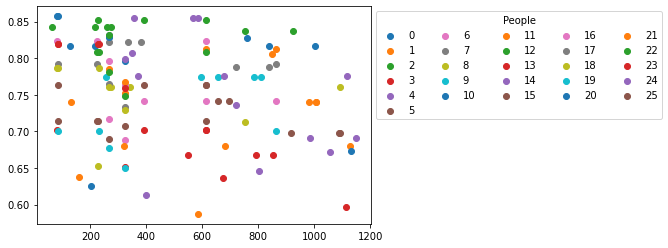

In [24]:
fig, ax = plt.subplots()

for count, (data, idx) in enumerate(zip(dataSet, series)):
    ax.scatter(idx, data, label = count)
EntVals = []
for k,v in best.items():
    EntVals.append(Entropy[k,v])
ax.legend(title = "People", loc = "upper left", bbox_to_anchor = (1, 1), ncol = math.floor(math.sqrt(disp.shape[0])), fancybox = True)
plt.show()

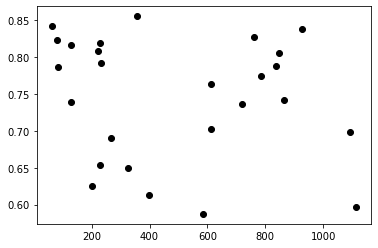

In [25]:
plt.scatter(best.values(), EntVals, c='black')
plt.show()